# 数据处理


In [3]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales = df_sales.drop_duplicates() #删除重复的数据行
df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价

## 整理数据集记录的时间范围

In [4]:
import numpy as np #导入NumPy
import pandas as pd #导入Pandas
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [ ]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

## 构建特征和标签

In [5]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')].copy() #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14214,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14215,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14216,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14217,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


In [6]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

,用户码,R值,F值,M值
0,15100,49,3,876.00
1,15291,41,33,1372.19
2,14688,6,82,1491.37
3,15311,5,693,12859.50
4,15862,89,64,354.23
...,...,...,...,...
356,15951,1,22,375.17
357,14745,1,7,240.60
358,15724,0,5,103.65
359,15874,0,5,584.35


In [13]:
df_sales[df_sales['用户码'] == 15656]['总价'].sum()

np.float64(1425.9)

In [7]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user_LTV, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,49,3,876.00,876.00
1,15291,41,33,1372.19,4668.30
2,14688,6,82,1491.37,5579.10
3,15311,5,693,12859.50,60632.75
4,15862,89,64,354.23,832.88
...,...,...,...,...,...
356,15951,1,22,375.17,708.22
357,14745,1,7,240.60,1220.26
358,15724,0,5,103.65,218.25
359,15874,0,5,584.35,4405.88


## 创建特征集和标签集

In [14]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

,R值,F值,M值
0,49,3,876.00
1,41,33,1372.19
2,6,82,1491.37
3,5,693,12859.50
4,89,64,354.23


In [15]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      876.00
1     4668.30
2     5579.10
3    60632.75
4      832.88
Name: 年度LTV, dtype: float64

## 拆分训练集、验证集和测试集

In [16]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

# 选择算法创建模型

In [17]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型
model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型

# 训练模型

In [18]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

# 评估模型

In [19]:
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.3239
验证集上的R平方分数-决策树: 0.1312
验证集上的R平方分数-随机森林: 0.3549


Text(0.5, 1.0, '实际值 vs. 预测值')

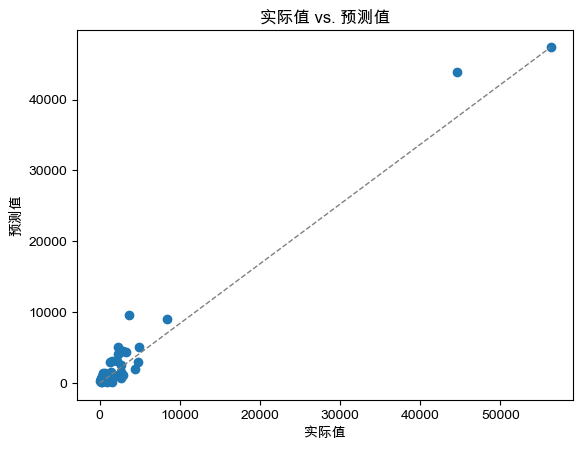

In [24]:
import matplotlib.pyplot as plt
# 设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC']  # macOS 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

y_test_preds = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集
plt.scatter(y_test, y_test_preds) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题